<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Application-of-frames-and-transformations:-Odometry" data-toc-modified-id="Application-of-frames-and-transformations:-Odometry-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Application of frames and transformations: Odometry</a></span><ul class="toc-item"><li><span><a href="#What-is-Odometry?" data-toc-modified-id="What-is-Odometry?-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>What is Odometry?</a></span></li></ul></li><li><span><a href="#Computing-the-body-fixed-motion-of-Romi's-frame" data-toc-modified-id="Computing-the-body-fixed-motion-of-Romi's-frame-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Computing the body-fixed motion of Romi's frame</a></span><ul class="toc-item"><li><span><a href="#Finding-Romi's-yaw-rate-$\dot{\psi}$" data-toc-modified-id="Finding-Romi's-yaw-rate-$\dot{\psi}$-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Finding Romi's yaw rate $\dot{\psi}$</a></span></li><li><span><a href="#Finding-the-velocity-of-Romi's-centroid,-$\vec{v}_{B}$" data-toc-modified-id="Finding-the-velocity-of-Romi's-centroid,-$\vec{v}_{B}$-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Finding the velocity of Romi's centroid, $\vec{v}_{B}$</a></span></li></ul></li><li><span><a href="#Using-$\dot{\psi}$-and-$\vec{v}_B$-to-complete-our-odometry-estimates" data-toc-modified-id="Using-$\dot{\psi}$-and-$\vec{v}_B$-to-complete-our-odometry-estimates-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Using $\dot{\psi}$ and $\vec{v}_B$ to complete our odometry estimates</a></span></li></ul></div>

## Application of frames and transformations: Odometry


One of the most important things for a (mobile) robot to "know" is *where it is in space*. There are many ways for it to measure this! These ways include GPS sensors, map and landmark-based localization strategies that use sensors like camera or LIDAR, world-fixed camera systems like the motion tracker in AEC 500... the list goes on.

However, most localization methods rely on measurements that either only give partial or relative location information (such as sensors that measure landmarks around the robot) or that are subject to dropouts and large errors (such as GPS). This means that most robots, in *addition* to using sensors to determine where they are, also keep track of their own motion using a technique called *odometry* or *dead reckoning*. This technique basically amounts to a robot integrating its own velocity over time to keep track of where it is. Obviously, a robot's own sense of its velocity is in a *body-fixed* frame, so the robot needs to convert its velocities into the allocentric (world-fixed) frame before integrating them, which requires a measurement of the robot's *orientation* as well.

This method isn't very accurate, because errors in velocity and heading compound over time when they're integrated. However, it's better than nothing, and it's fairly accurate for "short bursts" when global measurements are not available. We will get into how robots can combine their measurements of their "ego-motion" (using body-fixed sensors) with allocentric sensors to create a complete picture of their own motion, but that will be one of the last topics we cover in ES302.


### What is Odometry?

Odometry or dead reckoning for a robot moving on a plane is computing a robot's global position by integrating its global velocity. It consists of these steps, which occur in each "loop" of a program running on the robot (in other words, at every timestep $k$):

1. Compute the body-fixed velocity of the robot $^B\vec{v}$ and the robot's angular velocity $^B\vec{\omega}$
2. Transform these into the allocentric frame by computing $^A\vec{v}$ and $^A\vec{\omega}$
3. Integrate $^A\vec{\omega}$ to find the orientation of the robot in the global (allocentric) frame
4. Using the robot's orientation, transform $^B\vec{v}$ into $^A\vec{v}$ to get the robot's allocentric velocity
5. Integrate $^A\vec{v}$ to get the position of the robot in the allocentric frame.

Note that this list of steps assumes that the robot does not have an allocentric orientation sensor (such as a compass). If it does, you can skip step 3!

## Computing the body-fixed motion of Romi's frame

The Romi robot (and others like it) have sensors called [encoders](https://en.wikipedia.org/wiki/Incremental_encoder) attached to each wheel. An encoder measures the angular position traveled by each wheel on the robot. This means that with the correct unit conversions from encoder 'counts' to radians, and then from angular rotation to translational motion using a model of the wheel as an idealized [rotational to translational transducer](01_Background_Resources/01B_ES103_Summary_Resource.ipynb#ES103-List-of-Standard-Elements-and-Assumptions), we can compute the velocity of each of the Romi's wheels approximately as $v=\frac{\Delta_x}{\Delta_t}$. In the case of a "Roomba Style" robot like the Romi, we know that each of these wheel velocities is in the $\hat{x}_B$ direction as long as the no-slip assumption at the contact between wheel and ground is not violated.

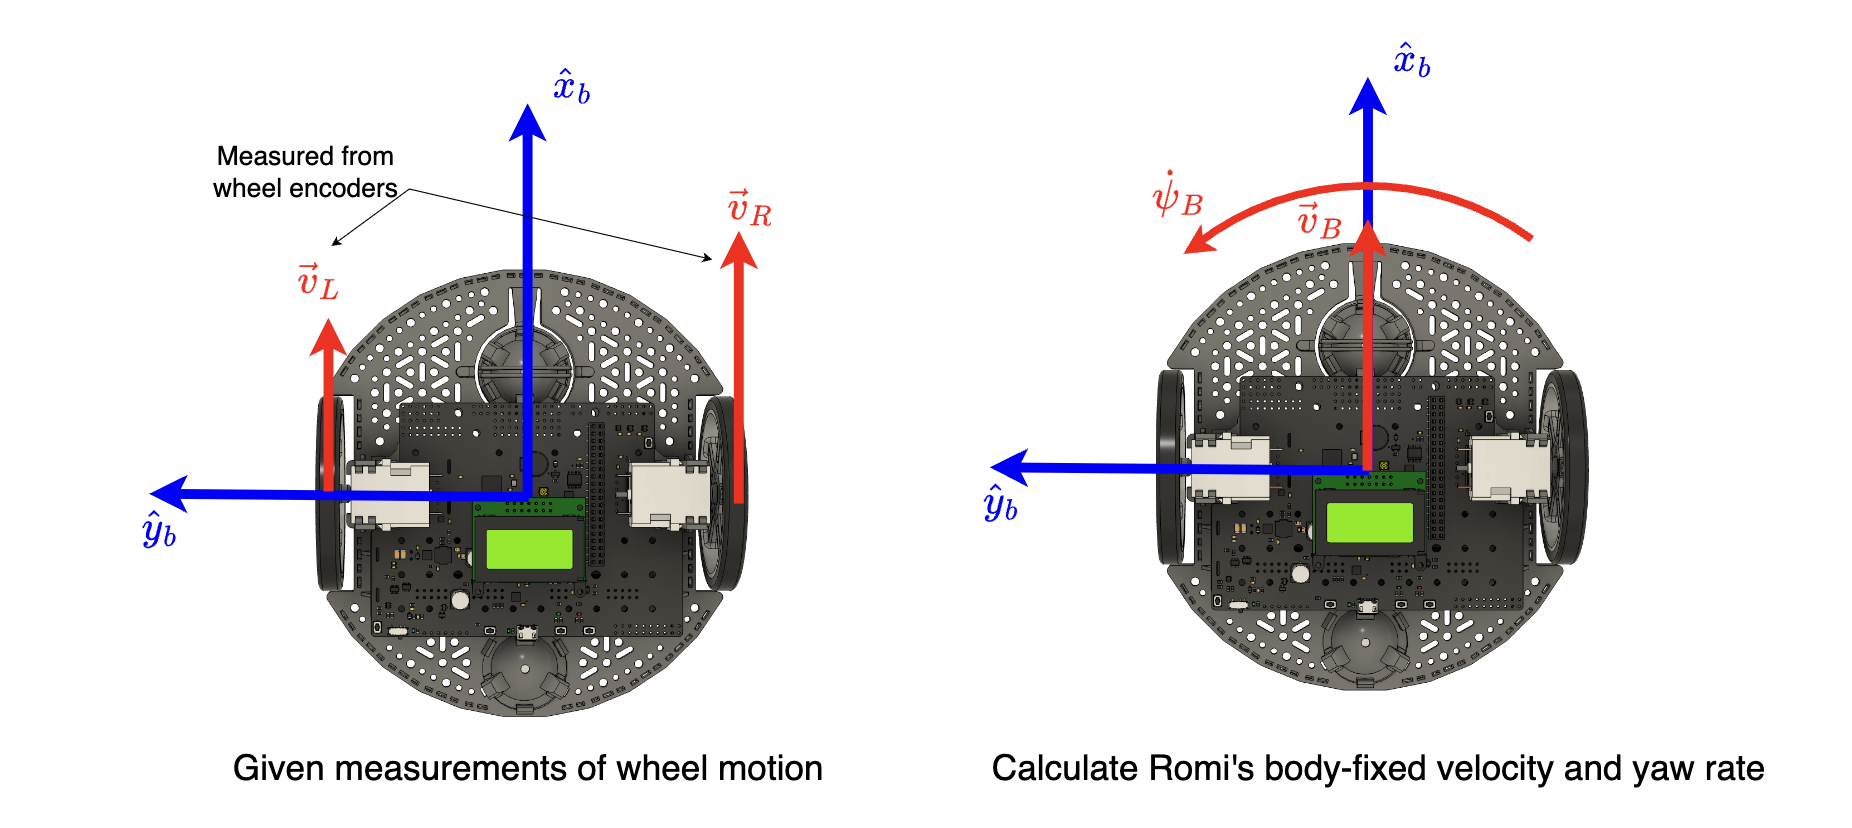

This is great, but it doesn't tell us what we need to perform the steps for Odometry estimation. We need to know $^A\vec{\omega}=^B\vec{\omega}=\dot{\psi}\hat{z}_{b/a}$, and we need to know the velocity of the *center* of the Romi, $^B\vec{v}_B$.

To compute these, we will use a concept you learned in ME240 (Dynamics)! We will use [relative motion of a rigid body](https://ocw.mit.edu/courses/16-07-dynamics-fall-2009/befffaf20475c1a379c3ac52e91a78cb_MIT16_07F09_Lec21.pdf). 

In ME240, you learned that the velocity of any point $b$ on a rigid body can be written as a function of the velocity of another point $a$, the relative position of $b$ relative to $a$ ($\vec{r}_{b/a}$), and the body's angular velocity ($\vec{\omega}$) via the equation:

\begin{equation}
\vec{v}_b = \vec{v}_a + \vec{\omega}\times\vec{r}_{b/a}
\end{equation}

### Finding Romi's yaw rate $\dot{\psi}$

We can use this equation to back out $\vec{\omega} = \dot{\psi}\hat{k}$ using our measured velocities $^B\vec{v}_L=v_L\hat{x}_B,^B\vec{v}_R=v_R\hat{x}_B$, along with the "radius" of the Romi, which we'll call $r$. 

Relating the known velocities of the left and right wheels, and writing $^B\vec{r}_{L/R} =2r\hat{x}_b$, we can construct the relative velocity equation relating the left wheel's velocity to the right.

\begin{equation}
\begin{aligned}
^B\vec{v}_{L} &= ^B\vec{v}_R + \dot{\psi}\hat{z}_B \times 2r \hat{y}_B \\
v_L\hat{x}_B &= v_R\hat{x}_B - 2r\dot{\psi}\hat{x}_B
\end{aligned}
\end{equation}

Because each term is multiplied by the same unit vector $\hat{x}_B$, this becomes a scalar equation that we can solve for $\dot{\psi}$.

\begin{equation}
\dot{\psi} = \frac{v_R-v_L}{2r}
\end{equation}

A unit check confirms that the equation has the correct units (rad/s).

### Finding the velocity of Romi's centroid, $\vec{v}_{B}$

To find $\vec{v}_{B}$, we can simply apply the rigid body formula again, now that we *know* Romi's yaw rate. Using the left wheel as our reference point, we find:

\begin{equation}
\vec{v}_B = \vec{v}_L + \vec{\omega}\times\vec{r}_{B/L}
\end{equation}

Substituting the position vector and angular velocity specific to the Romi, we find:

\begin{equation}
\vec{v}_B = {v}_L\hat{x}_B + \dot{\psi}\hat{z}_B \times -r \hat{y}_B
\end{equation}

Notice that $\vec{r}_{B/A}=-r\hat{y}_B$ because to get from the left wheel to the romi's center, you must move in the negative y-direction.

Performing the cross product $\hat{z}_B\times-\hat{y}_B=\hat{x}_B$ using the right-hand rule, and realizing that $\vec{v}_L=v_L\hat{x}_B$ tells us that the result we get for $\vec{v}_B$ will necessarily also be in the $\hat{x}_B$ direction. This means we can solve for the scalar magnitude $v_B$, which, after some algebra, is:

\begin{equation}
v_b = \frac{v_L+v_R}{2}
\end{equation}

## Using $\dot{\psi}$ and $\vec{v}_B$ to complete our odometry estimates

Integrating the Romi's angular velocity $\dot{\psi}$ allows us to estimate the robot's yaw angle $\psi$, which we can use to perform a *rotation* on the Romi's body-fixed velocity $^B\vec{v}_B$ before integrating to get global position estimates $^AX,^AY$. This can be accomplished by performing the rotation from body-fixed to global frames.

\begin{equation}
^A\vec{v}=_B^AR_z(\psi) ^B\vec{v}
\end{equation}

Where: $_B^A R_z(\psi)$ in 2D is given by:

\begin{equation}
_B^A R(\psi)=\begin{bmatrix} \cos\psi & -\sin\psi  \\ \sin\psi & \cos\psi   \end{bmatrix}
\end{equation}